In [2]:
import pandas as pd
import pickle
import re

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from keras import layers
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten
from keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import re
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder

2023-09-11 10:14:00.726554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('/Users/januardopanggabean/Challenge Platinum Binar/data/processed_data.csv', header=None ).drop(0)
df.columns=['clean_text', 'stopw_clean','label']
df

,clean_text,stopw_clean,label
1,warung ini dimiliki oleh pengusaha pabrik tahu...,warung dimiliki pengusaha pabrik puluhan terke...,positive
2,mohon ulama lurus dan k212 mmbri hujjah paai a...,mohon ulama lurus k212 mmbri hujjah paai diwlh...,neutral
3,lokasi strategis di jalan sumatera bandung tem...,lokasi strategis jalan sumatera bandung nya ny...,positive
4,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya unboxing paket barang nya b...,positive
5,duh jadi mahasiswa jangan sombong dong kasih k...,duh mahasiswa sombong kasih kau kuning belajar...,negative
...,...,...,...
10996,tidak kecewa,kecewa,positive
10997,enak rasa masakan nya apalagi kepiting yang me...,enak masakan nya kepiting menyenangkan memilih...,positive
10998,hormati paai paai yang telah berkoalisi,hormati paai paai berkoalisi,neutral
10999,pagi pagi di tol pasteur sudah macet parah bik...,pagi pagi tol pasteur macet parah bikin jengkel,negative


In [4]:
neg = df.loc[df['label'] == 'negative'].clean_text.tolist()
neu = df.loc[df['label'] == 'neutral'].clean_text.tolist()
pos = df.loc[df['label'] == 'positive'].clean_text.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [5]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [6]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

In [7]:
print(train_data.shape)


(7040, 3)


In [8]:
tokenizer = Tokenizer(oov_token='<UNK>')

In [9]:
tokenizer.fit_on_texts(train_data['clean_text'])

In [10]:
train_data_tf = tokenizer.texts_to_sequences(train_data['clean_text'])
val_data_tf = tokenizer.texts_to_sequences(val_data['clean_text'])
test_data_tf = tokenizer.texts_to_sequences(test_data['clean_text'])

In [11]:
max_len = int(np.quantile([len(x) for x in train_data_tf], 0.9))

train_padded = pad_sequences(sequences=train_data_tf,
                             padding='post',maxlen = max_len)
val_padded = pad_sequences(sequences=val_data_tf,padding='post', maxlen=max_len)
test_padded = pad_sequences(sequences=test_data_tf,padding='post',maxlen=max_len)

In [13]:
onehot = OneHotEncoder()

In [14]:
train_labels = onehot.fit_transform(train_data[['label']]).toarray()
valid_labels = onehot.transform(val_data[['label']]).toarray()
test_labels = onehot.transform(test_data[['label']]).toarray()

In [15]:
from tensorflow.keras.models import Sequential
model = Sequential()

In [50]:
max_features = len(tokenizer.index_word)
batch_sizes=32
output_dims=64
labels_tmp=32
input_len = max_len

In [30]:
print(max_len)

60


In [17]:
len(tokenizer.index_word)

13643

In [51]:
model = Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                 output_dim=output_dims, 
                                 input_length=max_len))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [52]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
maximum_index_training = int(np.floor(train_padded.shape[0]/batch_sizes)*batch_sizes)
model.fit(x=train_padded[:maximum_index_training], 
          y=train_labels[:maximum_index_training],
          batch_size=batch_sizes,
          epochs=20,
          shuffle=True
         )

Epoch 1/20
220/220 [==============================] - 15s 55ms/step - loss: 0.8674 - accuracy: 0.6156
Epoch 2/20
220/220 [==============================] - 12s 56ms/step - loss: 0.8997 - accuracy: 0.5955
Epoch 3/20
220/220 [==============================] - 12s 54ms/step - loss: 0.8275 - accuracy: 0.6341
Epoch 4/20
220/220 [==============================] - 12s 54ms/step - loss: 0.5847 - accuracy: 0.7719
Epoch 5/20
220/220 [==============================] - 12s 54ms/step - loss: 0.5693 - accuracy: 0.7723
Epoch 6/20
220/220 [==============================] - 12s 54ms/step - loss: 0.5598 - accuracy: 0.7689
Epoch 7/20
220/220 [==============================] - 12s 56ms/step - loss: 0.5022 - accuracy: 0.8077
Epoch 8/20
220/220 [==============================] - 12s 55ms/step - loss: 0.3808 - accuracy: 0.8494
Epoch 9/20
220/220 [==============================] - 12s 55ms/step - loss: 0.4446 - accuracy: 0.8220
Epoch 10/20
220/220 [==============================] - 12s 55ms/step - loss: 0.386

In [63]:
model2 = Sequential()
model2.add(layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                 output_dim=100, 
                                 input_length=max_len))
model2.add(layers.LSTM(64, dropout=0.2))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

from keras.optimizers import SGD
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

maximum_index_training = int(np.floor(train_padded.shape[0]/batch_sizes)*batch_sizes)
model2.fit(x=train_padded[:maximum_index_training], 
          y=train_labels[:maximum_index_training],
          batch_size=batch_sizes,
          epochs=20,
          shuffle=True
         )

Epoch 1/20
220/220 [==============================] - 11s 37ms/step - loss: 0.8688 - accuracy: 0.6030
Epoch 2/20
220/220 [==============================] - 8s 37ms/step - loss: 0.7938 - accuracy: 0.6509
Epoch 3/20
220/220 [==============================] - 7s 34ms/step - loss: 0.8971 - accuracy: 0.5955
Epoch 4/20
220/220 [==============================] - 7s 30ms/step - loss: 0.8117 - accuracy: 0.6452
Epoch 5/20
220/220 [==============================] - 6s 29ms/step - loss: 0.5741 - accuracy: 0.7777
Epoch 6/20
220/220 [==============================] - 7s 31ms/step - loss: 0.4286 - accuracy: 0.8251
Epoch 7/20
220/220 [==============================] - 7s 30ms/step - loss: 0.2700 - accuracy: 0.9143
Epoch 8/20
220/220 [==============================] - 6s 29ms/step - loss: 0.1693 - accuracy: 0.9476
Epoch 9/20
220/220 [==============================] - 7s 30ms/step - loss: 0.1160 - accuracy: 0.9648
Epoch 10/20
220/220 [==============================] - 7s 30ms/step - loss: 0.0854 - accur

Epoch 1/20
220/220 [==============================] - 8s 38ms/step - loss: 0.0184 - accuracy: 0.9967 - val_loss: 1.1106 - val_accuracy: 0.8068
Epoch 2/20
220/220 [==============================] - 8s 36ms/step - loss: 0.0301 - accuracy: 0.9935 - val_loss: 1.1882 - val_accuracy: 0.8153
Epoch 3/20
220/220 [==============================] - 8s 35ms/step - loss: 0.0190 - accuracy: 0.9966 - val_loss: 1.1917 - val_accuracy: 0.8131
Epoch 4/20
220/220 [==============================] - 8s 36ms/step - loss: 0.0163 - accuracy: 0.9969 - val_loss: 1.3300 - val_accuracy: 0.8119
Epoch 5/20
220/220 [==============================] - 8s 35ms/step - loss: 0.0335 - accuracy: 0.9874 - val_loss: 1.1535 - val_accuracy: 0.8131
Epoch 6/20
220/220 [==============================] - 8s 35ms/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 1.1887 - val_accuracy: 0.8125
Epoch 7/20
220/220 [==============================] - 8s 37ms/step - loss: 0.0165 - accuracy: 0.9963 - val_loss: 1.2045 - val_accuracy: 0.8108

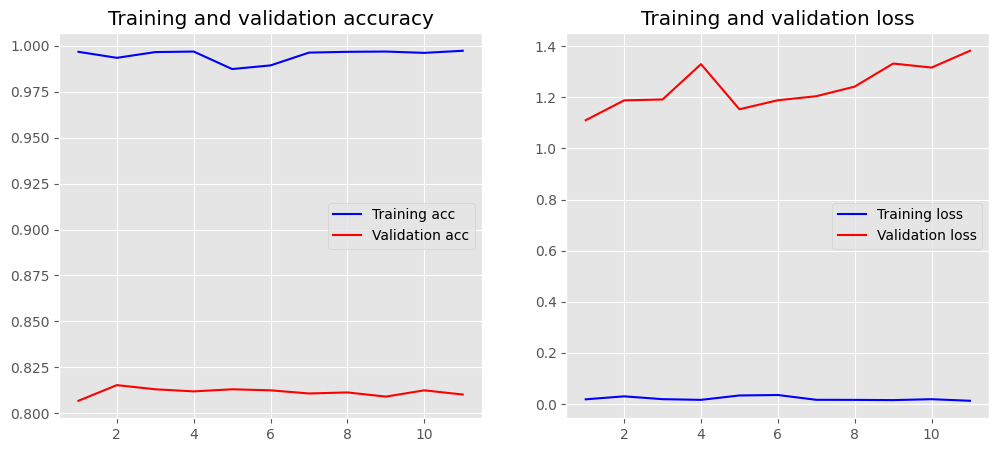

In [64]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Train your model and store the training history using the `history` object
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history2 = model2.fit(train_padded, train_labels, epochs=20, batch_size=batch_sizes, validation_data=(val_padded, valid_labels),shuffle=True, callbacks=[early_stopping])

def plot_history(history2):
    acc = history2.history['accuracy']  # Access accuracy from history object
    val_acc = history2.history['val_accuracy']  # Access validation accuracy from history object
    loss = history2.history['loss']  # Access training loss from history object
    val_loss = history2.history['val_loss']  # Access validation loss from history object
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history2)


In [61]:
pickle.dump(model, open('model_lstm.h5','wb'))

In [62]:
model.save('lstmmodels.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
pickle.dump(onehot, open('onehot.pkl', 'wb'))

In [64]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [65]:
pickle.dump(pad_sequences, open('pad_sequence.pkl', 'wb'))

In [66]:
pickle.dump(input_len, open('input_len.pkl', 'wb'))

In [27]:
y_predict = model.predict(val_padded, batch_size=1)

1760/1760 [==============================] - 9s 5ms/step


In [35]:
y_predictive = onehot.inverse_transform(y_predict).reshape(-1)
accuracy_score(y_pred=y_predictive, y_true=val_data['label'])

0.8403409090909091

In [69]:
with open('/Users/januardopanggabean/VSCE Platinum Challenge/FD Materials/model_lstm.h5', 'rb') as file:
    loaded_model = pickle.load(file)

# Verify the loaded model (optional)
print(loaded_model)

Epoch 1/20
220/220 [==============================] - 14s 63ms/step - loss: 0.0221 - accuracy: 0.9949 - val_loss: 0.9947 - val_accuracy: 0.8182
Epoch 2/20
220/220 [==============================] - 13s 60ms/step - loss: 0.0371 - accuracy: 0.9886 - val_loss: 0.9742 - val_accuracy: 0.8170
Epoch 3/20
220/220 [==============================] - 15s 67ms/step - loss: 0.0239 - accuracy: 0.9935 - val_loss: 1.0016 - val_accuracy: 0.8097
Epoch 4/20
220/220 [==============================] - 14s 66ms/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 1.1296 - val_accuracy: 0.8068
Epoch 5/20
220/220 [==============================] - 13s 60ms/step - loss: 0.0232 - accuracy: 0.9940 - val_loss: 1.0435 - val_accuracy: 0.8148
Epoch 6/20
220/220 [==============================] - 13s 60ms/step - loss: 0.0149 - accuracy: 0.9962 - val_loss: 1.1568 - val_accuracy: 0.8159
Epoch 7/20
220/220 [==============================] - 13s 61ms/step - loss: 0.0125 - accuracy: 0.9966 - val_loss: 1.3119 - val_accuracy:

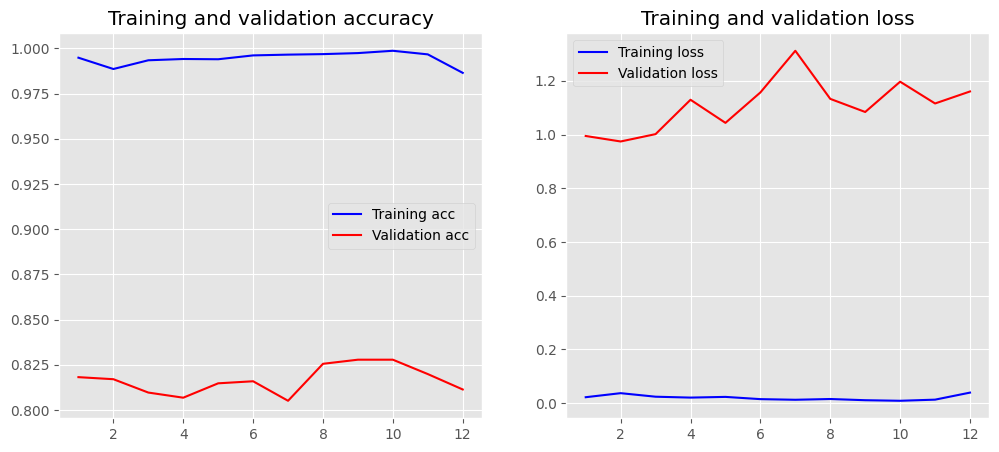

In [54]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Train your model and store the training history using the `history` object
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(train_padded, train_labels, epochs=20, batch_size=batch_sizes, validation_data=(val_padded, valid_labels),shuffle=True, callbacks=[early_stopping])

def plot_history(history):
    acc = history.history['accuracy']  # Access accuracy from history object
    val_acc = history.history['val_accuracy']  # Access validation accuracy from history object
    loss = history.history['loss']  # Access training loss from history object
    val_loss = history.history['val_loss']  # Access validation loss from history object
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)


In [71]:
print(maximum_index_training)

7040


In [72]:
print(train_padded.shape)

(7040, 60)
